In [2]:
# import necessary packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

# set up relative paths
path = os.path.dirname('')
task_2_dir = os.path.join(path, '..', 'task_2')

# import dataset as panda dataframes
approved = pd.read_csv(os.path.join(task_2_dir, 'approved_drugs.csv'), index_col = 0)
spike = pd.read_csv(os.path.join(task_2_dir, 'spike_positive_compounds.csv'), index_col = 0)

# Find out the data types of the features in each df
print('datatypes by features in approved dataset:\n',approved.dtypes)
print('datatypes by features in spike dataset:\n',spike.dtypes)


datatypes by features in approved dataset:
 feature_1     object
feature_2    float64
feature_3    float64
dtype: object
datatypes by features in spike dataset:
 feature_1     object
feature_2    float64
feature_3    float64
dtype: object


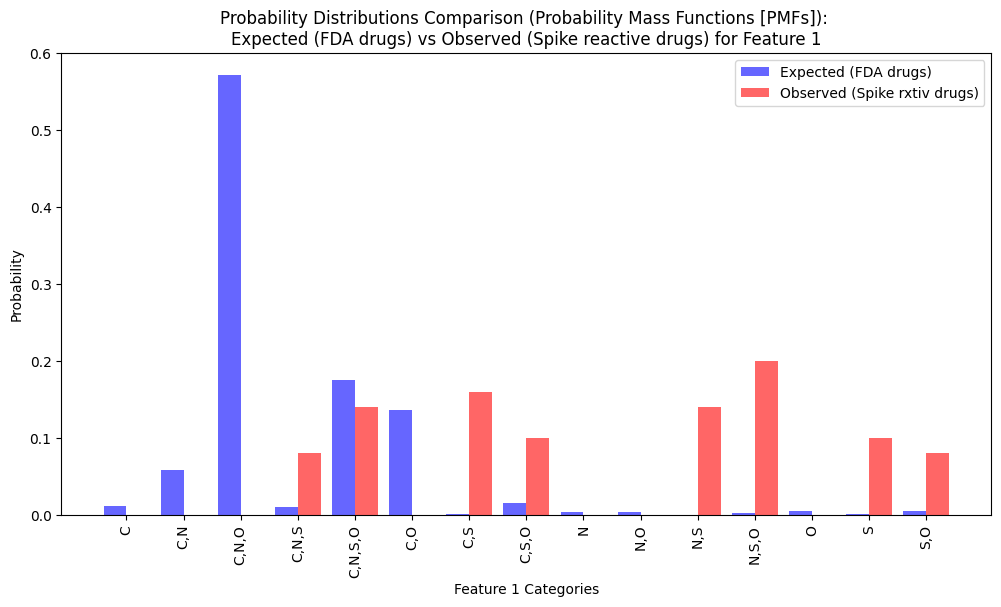


Feature_1 *is significantly different* (at alpha = 0.05) 
in spike reactive drug set vs approved drug dataset, with 
p-value = 1e-10 & 
test statistic = 7197.5002188622575

Feature_1 *is significantly different* (at alpha = 0.01) 
in spike reactive drug set vs approved drug dataset, with 
p-value = 1e-10 & 
test statistic = 7197.5002188622575


In [6]:
# EDA on Feature 1, then chi squared test (spike vs approved)

# extract value counts of feature_1 items in approved dataset, set to population counts
approved_counts = approved['feature_1'].value_counts().rename('population')

# extract value counts of feature_1 items in spike dataset, set to observed counts
spike_counts = spike['feature_1'].value_counts().rename('observed')

# inner merge to get shared features only for chi squared test and create a contingency table for the test
contig_df = pd.merge(approved_counts, spike_counts, left_index = True, right_index = True, how = 'outer').fillna(0)

# create population probability (ratios of feature_1 outcomes in approved dataset) to model the population
contig_df['population_proba'] = contig_df['population']/contig_df['population'].sum()

# generate expected counts based on population probability 
contig_df['expected'] = contig_df['population_proba'] * contig_df['observed'].sum()

# plot the probability mass functions side by side
plt.figure(figsize=(12, 6))
bar_width = 0.4
x = np.arange(len(contig_df.index))
plt.bar(x - bar_width/2, contig_df['expected']/contig_df['expected'].sum(), width=bar_width, color='blue', alpha=0.6, label='Expected (FDA drugs)')
plt.bar(x + bar_width/2, contig_df['observed']/contig_df['observed'].sum(), width=bar_width, color='red', alpha=0.6, label='Observed (Spike rxtiv drugs)')
plt.xticks(x, contig_df.index, rotation=90)
plt.xlabel("Feature 1 Categories")
plt.ylabel("Probability")
plt.title("Probability Distributions Comparison (Probability Mass Functions [PMFs]): \nExpected (FDA drugs) vs Observed (Spike reactive drugs) for Feature 1")
plt.legend()
plt.show()

def alpha_crit(stat, pvalue, alpha, featname): 
    """
    Type I error control function that reports if a test statistic is significant

    Parameters
    ----------
    stat : float64
        the test-statistic value 
    pvalue : float64
        the probability of observing the test-statistic
    alpha : float 64
        user defined threshold for type I error control under null hypothesis
    featname : str
        the name of the variable being tested

    """
    # test if pvalue less than alpha
    if pvalue < alpha:
        # float error control for super small p-values and then 
        pvalue = 1e-10 if pvalue < 1e-10 else str(pvalue) 
        print(f'\n{featname} *is significantly different* (at alpha = {alpha}) \nin spike reactive drug set vs approved drug dataset, with \np-value = {pvalue} & \ntest statistic = {stat}')
    else:
        print(f'\n{featname} *is not significantly different* (at alpha = {alpha}) \nin spike reactive drug set vs approved drug dataset, with \np-value = {pvalue} & \ntest statistic = {stat}')

# perform chisquare test using expected counts (modelled from FDA drugs) and observed count (spike protein responsive drugs)
chistat, pvalue = scipy.stats.chisquare(f_obs=contig_df['observed'], f_exp=contig_df['expected'])

# set an array of alphas to test
alphas = np.array([0.05, 0.01])

# report chi square test results
for alpha in alphas:
    alpha_crit(stat = chistat, pvalue = pvalue, alpha = alpha, featname = 'Feature_1')

Approved drug dataset, summary statistics:
count    4913.000000
mean        0.207669
std        11.525513
min       -44.852145
25%        -8.750197
50%         0.234278
75%         9.464845
max        32.993710
Name: feature_2, dtype: float64

Spike drug dataset, summary statistics:
count    50.000000
mean     14.705413
std       4.528186
min      10.146325
25%      11.600307
50%      13.110948
75%      16.387991
max      31.173711
Name: feature_2, dtype: float64


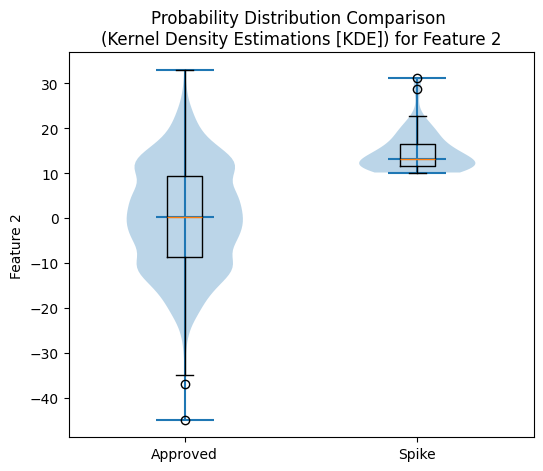


Feature_2 *is significantly different* (at alpha = 0.05) 
in spike reactive drug set vs approved drug dataset, with 
p-value = 1e-10 & 
test statistic = -21.92787245790435

Feature_2 *is significantly different* (at alpha = 0.01) 
in spike reactive drug set vs approved drug dataset, with 
p-value = 1e-10 & 
test statistic = -21.92787245790435


In [7]:
# EDA on Feature 2, then Welch-test (spike vs approved)

# prints summary statistics
print(f"Approved drug dataset, summary statistics:\n{approved['feature_2'].describe()}\n\n"
      f"Spike drug dataset, summary statistics:\n{spike['feature_2'].describe()}")

# plot PDF (using kde estimation from violin plot)
fig, ax = plt.subplots(figsize=(6, 5))
data = [approved['feature_2'].dropna(), spike['feature_2'].dropna()]
parts = ax.violinplot(data, positions=[1, 2], showmeans=False, showmedians=True)
ax.boxplot(data, widths=0.15, labels=['Approved', 'Spike'])
ax.set_title('Probability Distribution Comparison \n(Kernel Density Estimations [KDE]) for Feature 2')
ax.set_xticks([1, 2])
ax.set_xticklabels(['Approved', 'Spike'])
ax.set_ylabel('Feature 2')
plt.show()

# perform t-test using unequal variance (the Welch-test), as the variances in each condition are unequal 
tstat, pvalue = scipy.stats.ttest_ind(approved['feature_2'], spike['feature_2'], equal_var = False)

# reports test
for alpha in alphas:
    alpha_crit(stat = tstat, pvalue = pvalue, alpha = alpha, featname = 'Feature_2')


Approved drug dataset, summary statistics:
count    4913.000000
mean        0.499595
std         0.287415
min         0.000132
25%         0.252323
50%         0.499155
75%         0.748173
max         0.999910
Name: feature_3, dtype: float64

Spike drug dataset, summary statistics:
count    50.000000
mean      0.445801
std       0.257356
min       0.004005
25%       0.236710
50%       0.453964
75%       0.652877
max       0.935747
Name: feature_3, dtype: float64


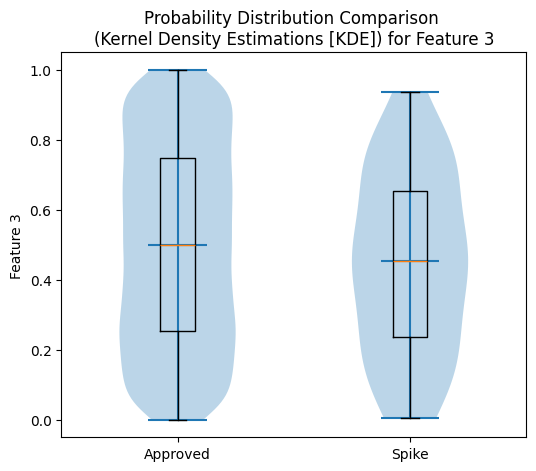


Feature_3 *is not significantly different* (at alpha = 0.05) 
in spike reactive drug set vs approved drug dataset, with 
p-value = 0.18754569271266547 & 
test statistic = 1.3180561927968157

Feature_3 *is not significantly different* (at alpha = 0.01) 
in spike reactive drug set vs approved drug dataset, with 
p-value = 0.18754569271266547 & 
test statistic = 1.3180561927968157


In [8]:
# EDA on Feature 3, then two-tailed, scalar EDA & two-sample independent t-test (spike vs approved)

# print summary statistics using pd.describe()
print(f"Approved drug dataset, summary statistics:\n{approved['feature_3'].describe()}\n\n"
      f"Spike drug dataset, summary statistics:\n{spike['feature_3'].describe()}")


# plot PDF (using kde estimation from violin plot)
fig, ax = plt.subplots(figsize=(6, 5))
data = [approved['feature_3'].dropna(), spike['feature_3'].dropna()]
parts = ax.violinplot(data, positions=[1, 2], showmeans=False, showmedians=True)
ax.boxplot(data, widths=0.15, labels=['Approved', 'Spike'])
ax.set_title('Probability Distribution Comparison \n(Kernel Density Estimations [KDE]) for Feature 3')
ax.set_xticks([1, 2])
ax.set_xticklabels(['Approved', 'Spike'])
ax.set_ylabel('Feature 3')
plt.show()

# performs two-sample independent t-test (two-tailed), using equal variance assumption to see 
# if feature 3 significantly differs in spike and approved datasets
tstat, pvalue = scipy.stats.ttest_ind(approved['feature_3'], spike['feature_3'], equal_var=True)

# reports test
for alpha in alphas:
    alpha_crit(stat = tstat, pvalue = pvalue, alpha = alpha, featname = 'Feature_3')

In [10]:
# Make a small report summarizing the significance findings for each feature

# feature 1 test (full)
chistat, pvalue_1 = scipy.stats.chisquare(f_obs=contig_df['observed'], f_exp=contig_df['expected'])
# feature 2 test (full)
tstat_2, pvalue_2 = scipy.stats.ttest_ind(approved['feature_2'], spike['feature_2'], equal_var = False)
# feature 3 test (full)
tstat_3, pvalue_3 = scipy.stats.ttest_ind(approved['feature_3'], spike['feature_3'], equal_var = True)

# construct df with summary stats
report_df = pd.DataFrame({ 'feature': ['feature_1', 'feature_2', 'feature_3'],
                            'datatype': ['ordinal','scalar','scalar'],
                            'test': ['chi-squared', 't-test','t-test'],
                            'test-statistic': [chistat, tstat_2, tstat_3],
                            'p-value': [pvalue_1, pvalue_2, pvalue_3],
                            'alpha=5%': ['is significant', 'is significant', 'not significant'],
                            'significance explanation': ['Sig. different categorical distributions [fda (expected) vs spike (observed)]',
                            'Sig. different expected values (mean) between groups [fda vs spike]',
                            'Not sig. different expected values (mean) between groups [fda vs spike]']}).set_index('feature')
# save the df
report_df.to_csv(os.path.join(task_2_dir, 'stat_report.csv'))

# print the df
report_df.head()

,datatype,test,test-statistic,p-value,alpha=5%,significance explanation
feature,,,,,,
feature_1,ordinal,chi-squared,7197.500219,0.000000e+00,is significant,Sig. different categorical distributions [fda ...
feature_2,scalar,t-test,-21.927872,4.584405e-29,is significant,Sig. different expected values (mean) between ...
feature_3,scalar,t-test,1.318056,1.875457e-01,not significant,Not sig. different expected values (mean) betw...
